# Adult DataSet
https://archive.ics.uci.edu/dataset/2/adult

###  Predict whether annual income of an individual exceeds $50K/yr based on census data. Also known as "Census Income" dataset.


## Data engineering & Data processing

### Libraries

In [180]:
import pandas as pd
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, RobustScaler, OneHotEncoder
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

### Dataset general information

In [74]:
# 1. Define variables from metadata

column_names = [
    'age', 'workclass', 'fnlwgt', 'education', 'education-num',
    'marital-status', 'occupation', 'relationship', 'race', 'sex',
    'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 
    'income'
]

In [75]:
# 2. load data
# index_col=0 handles the leading record ID; na_values='?' handles missing data [4, 5]

df = pd.read_csv("DATA/adult/adult.data", names=column_names,  header=0)
df.head(5)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
1,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
2,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
3,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
4,37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,<=50K


In [76]:
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 32560 entries, 0 to 32559
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   age             32560 non-null  int64
 1   workclass       32560 non-null  str  
 2   fnlwgt          32560 non-null  int64
 3   education       32560 non-null  str  
 4   education-num   32560 non-null  int64
 5   marital-status  32560 non-null  str  
 6   occupation      32560 non-null  str  
 7   relationship    32560 non-null  str  
 8   race            32560 non-null  str  
 9   sex             32560 non-null  str  
 10  capital-gain    32560 non-null  int64
 11  capital-loss    32560 non-null  int64
 12  hours-per-week  32560 non-null  int64
 13  native-country  32560 non-null  str  
 14  income          32560 non-null  str  
dtypes: int64(6), str(9)
memory usage: 3.7 MB


In [77]:
print(df.columns)

Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country',
       'income'],
      dtype='str')


##### What is one row semantically?
There is a white male who is 39 years old, works for state government, has a Bachlelor's degree, works 40 hours a week, lives in USA, this person is not married and earns less than 50K. 

#### What does one target value correspond to?
Target value is income

#### Is the dataset static or temporal?
There is no time stamp so its static

#### Are samples independent?
Yes, the samples are assumed to be independent.
One row represent one person.
i.i.d

### 2. Target variable understanding
#### Target type (binary / multiclass / continuous). --> binary classification 
#### Possible value range. --> > >50k or <= 50k
#### Class balance or distribution. --> normal
#### What a “good” vs “bad” value means

In [78]:
unique_targets = df['income'].nunique()
target_type = "Binary Classification" if unique_targets ==2 else "Multiclass/Cont"
print(f"Target Type: {target_type}")

Target Type: Binary Classification


In [79]:
value_range = df['income'].unique()
print(f"Possible Value Range: {value_range}")

Possible Value Range: <StringArray>
[' <=50K', ' >50K']
Length: 2, dtype: str


In [80]:
distribution = df['income'].value_counts(normalize=True) * 100
print("Class Distribution (%):")
print(distribution)

Class Distribution (%):
income
<=50K    75.918305
>50K     24.081695
Name: proportion, dtype: float64


In [81]:
# In socio-economic context [1], earning more is the positive/good outcome.
print("\nInterpretation:")
print(" - 'Good' (Positive Class): >50K (Higher Income)")
print(" - 'Bad' (Negative/Baseline Class): <=50K (Lower Income)")


Interpretation:
 - 'Good' (Positive Class): >50K (Higher Income)
 - 'Bad' (Negative/Baseline Class): <=50K (Lower Income)


#### Features documentation
1. Numeric Features
- age
    -- Type: Numeric, continuous, raw.
    -- Meaning: The individual's age in years; values are bounded.
    -- Quality: No missing values observed in excerpts; higher values often correlate with the >50K income class.
- fnlwgt (Final Weight)
    -- Type: Numeric, continuous, raw.
    -- Meaning: Represents the number of people the census entry signifies in the general population.
    -- Quality: Exhibits high variance and no obvious correlation with the target.
- education-num
    ◦ Type: Numeric, continuous, encoded (ordinal).
    ◦ Meaning: A numeric ranking of the highest education level reached.
    ◦ Quality: Strong positive correlation with target; high values like 13 (Bachelors) or 14 (Masters) appear frequently in the >50K class.
- capital-gain
    ◦ Type: Numeric, continuous, raw.
    ◦ Meaning: Profit from the sale of assets (Units: USD).
    ◦ Quality: Heavily skewed with most values at 0; high earners are capped at 99999.
- capital-loss
    ◦ Type: Numeric, continuous, raw.
    ◦ Meaning: Loss from the sale of assets (Units: USD).
    ◦ Quality: Heavily skewed with the majority of entries being 0.
- hours-per-week
    ◦ Type: Numeric, continuous, raw.
    ◦ Meaning: Average working hours per week.
    ◦ Quality: Bounded between 1 and 99; values significantly higher than 40 often correlate with the >50K class.
    
2. Categorical Features
- workclass
    ◦ Type: Categorical, discrete, raw.
    ◦ Meaning: Sector of employment (e.g., Private, State-gov).
    ◦ Quality: Contains missing values represented as ?.
- education
    ◦ Type: Categorical, discrete, raw.
    ◦ Meaning: Highest degree or level of schooling achieved.
    ◦ Quality: Redundant with education-num.
- marital-status
    ◦ Type: Categorical, discrete, raw.
    ◦ Meaning: Current civil status.
    ◦ Quality: "Married-civ-spouse" is the most frequent status among individuals earning >50K.
- occupation
    ◦ Type: Categorical, discrete, raw.
    ◦ Meaning: The specific job role held.
    ◦ Quality: Contains missing values represented as ?.
- relationship
    ◦ Type: Categorical, discrete, raw.
    ◦ Meaning: The person's role in the household (e.g., Husband, Wife).
- race
    ◦ Type: Categorical, discrete, raw.
    ◦ Meaning: Ethnic background.
    ◦ Quality: Heavily imbalanced distribution with "White" as the dominant category.
- sex
    ◦ Type: Categorical, discrete, raw.
    ◦ Meaning: Biological gender (Male/Female).
- native-country
    ◦ Type: Categorical, discrete, raw.
    ◦ Meaning: Country of origin.
    ◦ Quality: Near-constant column (dominated by "United-States") and contains missing values as ?.

### 4. Feature–Target Relationship
To understand the relationship between these features and the target income variable, we can categorize them by their timing, predictive strength, and potential for data leakage.

1. Temporal Relationship (Before vs. After)
In the context of this dataset, all features represent attributes collected at the same time as the income was recorded.

• Existing "Before": Demographic features like age, race, sex, and native-country are fixed traits. Education-related features (education, education-num) represent historical attainment reached prior to the income measurement.

• Concurrent Characteristics: Employment and social status (workclass, occupation, marital-status, hours-per-week) describe the individual's current situation that results in their income level.

• Result-Oriented: Features like capital-gain and capital-loss are financial outcomes that occur within the same year as the income measurement, but strictly speaking, they are collected simultaneously rather than "after" the income bracket is determined.

2. Indirect Revelation of Income
Several features serve as strong proxies that can indirectly reveal the income bracket:

• Education-Num: There is a heavy concentration of the >50K class among those with higher numeric rankings (e.g., 13 for Bachelors, 14 for Masters, 16 for Doctorate).

• Occupation: High-status roles like Exec-managerial and Prof-specialty are disproportionately associated with the >50K target across various records.

• Marital Status & Relationship: Being a Married-civ-spouse (often with a relationship status of Husband or Wife) appears as a strong indicator of the higher income bracket in many snippets.

3. Predictability and Realism
One feature in particular makes the prediction potentially "too easy" or unrealistic:

• Capital-Gain: In the source data, individuals with significant capital gains—specifically those at the cap of 99999—are almost exclusively associated with the >50K income category.

• The Risk: Because capital gains are technically a component of wealth/income, a model might "cheat" by simply looking for any non-zero value in this column to predict high income. This can lead to a model that performs perfectly on this dataset but fails to generalize to individuals whose income is derived solely from high wages rather than investment profit.

## EDA/Visualization
### Exploratory Data Analysis

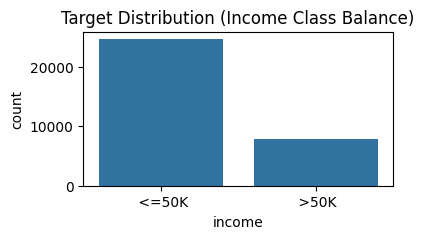

In [82]:
# 1. Visualize target distribution and class balance
plt.figure(figsize=(4,2))
sns.countplot(x= 'income' ,data=df)
plt.title('Target Distribution (Income Class Balance)')
plt.show()

['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'income']


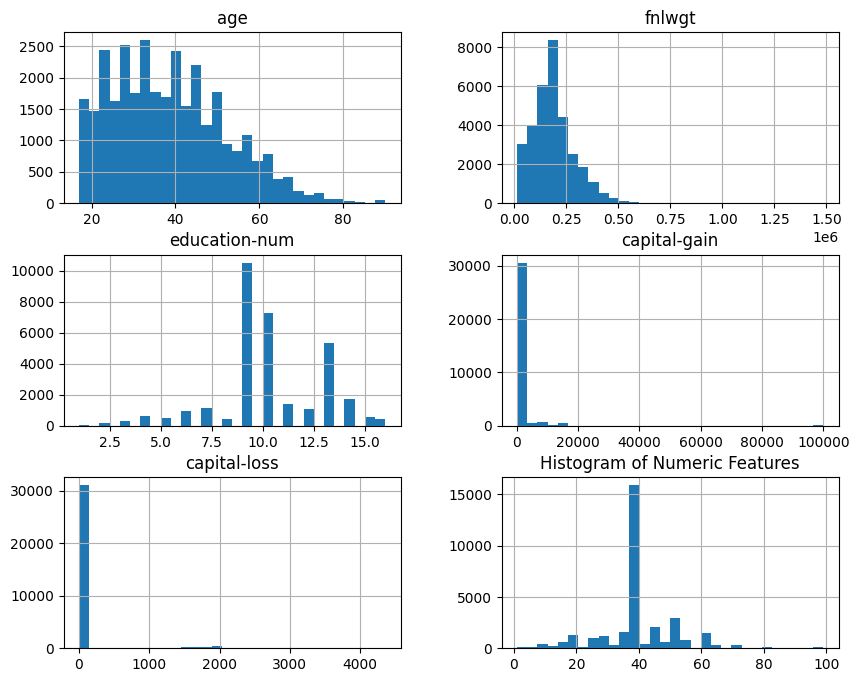

In [83]:
# 2. Visualize distributions of numeric features (Histograms)
print(column_names) #
numeric_features = ['age', 'fnlwgt', 'education-num',  'capital-gain', 'capital-loss', 'hours-per-week']
df[numeric_features].hist(figsize=(10,8), bins=30)
plt.title('Histogram of Numeric Features')
plt.show()

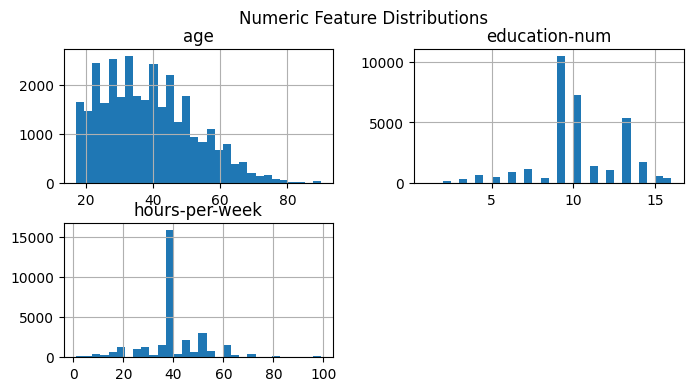

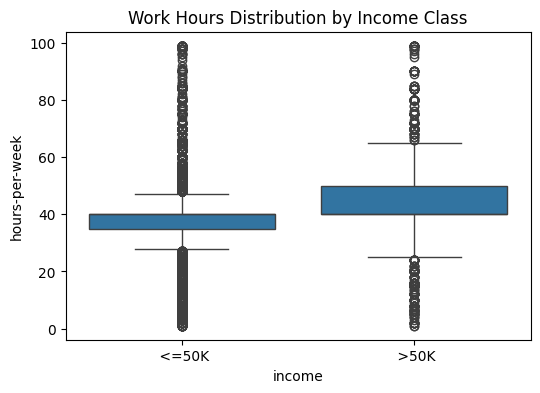

In [84]:
# Histogram for continuous numeric features
df[['age', 'education-num', 'hours-per-week']].hist(bins=30, figsize=(8, 4))
plt.suptitle("Numeric Feature Distributions")
plt.show()

# Box plot to see outliers and distribution by income bracket
plt.figure(figsize=(6, 4))
sns.boxplot(x='income', y='hours-per-week', data=df)
plt.title("Work Hours Distribution by Income Class")
plt.show()


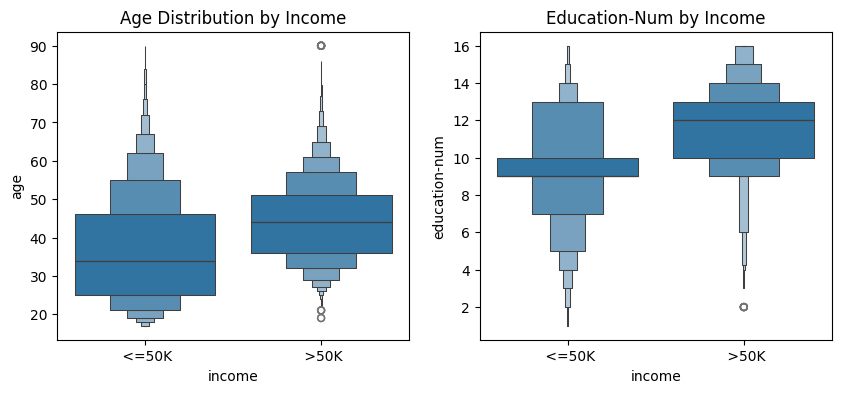

In [85]:
# 3. Compare feature distributions for different target values
# Example: Age and Education-Num by Income
plt.figure(figsize=(10,4))
plt.subplot(1, 2, 1)
sns.boxenplot(x='income' , y='age', data=df)
plt.title('Age Distribution by Income')

plt.subplot(1, 2, 2)
sns.boxenplot(x='income', y='education-num', data=df)
plt.title('Education-Num by Income')
plt.show()

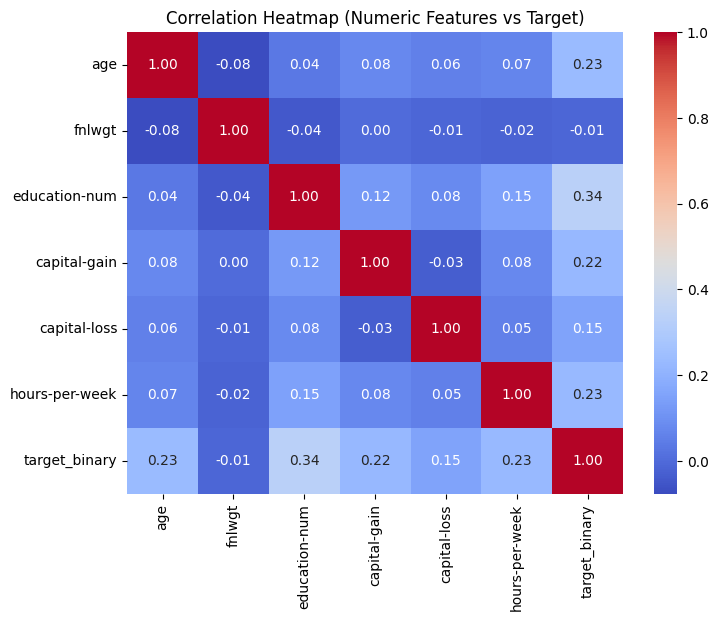

In [86]:
# 4. Check simple correlations between numeric features and the target
# Encode target to numeric for correlation calculation

df['target_binary'] = df['income'].str.strip().map({'>50K': 1, '<=50K': 0})
correlation_matrix = df[numeric_features + ['target_binary']].corr()

plt.figure(figsize=(8,6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap (Numeric Features vs Target)')
plt.show()

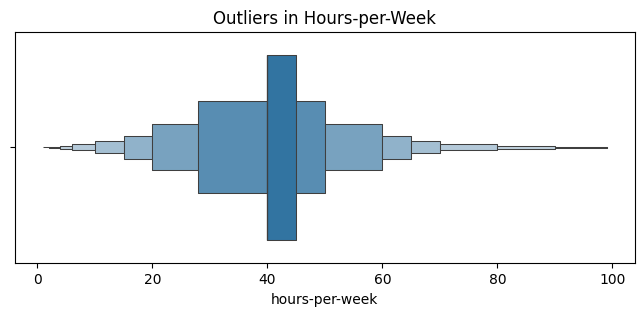

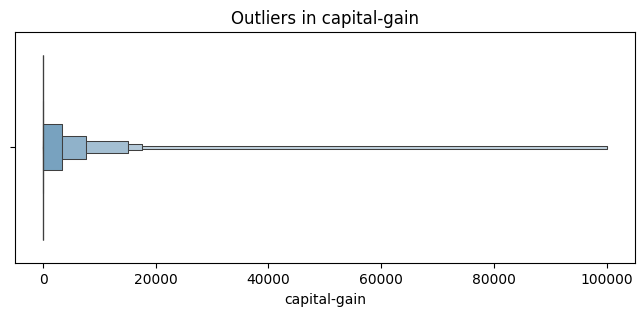

In [87]:
# 5. Identify outliers and unusual patterns
# Using box plots to see outliers in hours-per-week and capital-gain

plt.figure(figsize=(8,3))
sns.boxenplot(x=df['hours-per-week'])
plt.title('Outliers in Hours-per-Week')
plt.show()

plt.figure(figsize=(8,3))
sns.boxenplot(x=df['capital-gain'])
plt.title('Outliers in capital-gain')
plt.show()

In [88]:
# get outliers
# IQR method to find outliers
for col in numeric_features:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
    print(f"{col}: Found {len(outliers)} outliers")

age: Found 143 outliers
fnlwgt: Found 992 outliers
education-num: Found 1198 outliers
capital-gain: Found 2711 outliers
capital-loss: Found 1519 outliers
hours-per-week: Found 9008 outliers


In [89]:
# Special check for the capital-gain cap observed in source snippets
cap_value = 99999
capped_earners = df[df['capital-gain'] == cap_value]
print(f"\nRecords capped at 99999 capital-gain: {len(capped_earners)}")


Records capped at 99999 capital-gain: 159


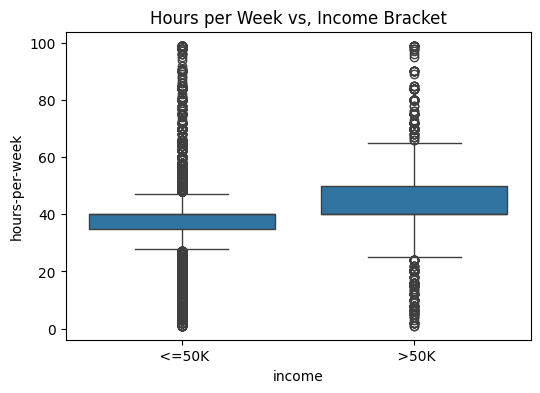

In [90]:
# Relationship with income
# Comparing work hours across the two income classes to dermine 
# if "working more" directly shifts somone into  the >50k bracket

plt.figure(figsize=(6,4))
# Box plot grouped by income
sns.boxplot(x='income', y='hours-per-week', data = df)
plt.title('Hours per Week vs, Income Bracket')
plt.show()

In [91]:
# Correlation Check
# Convert incom to numeric for correlation
#df['target_binary'] = df['income'].str.strip().map({'>50K': 1, '<=50K': 0})
correlation = df['hours-per-week'].corr(df['target_binary'])
print(f"Correlation between Hours-per-Week and Income: {correlation:.2f}")

Correlation between Hours-per-Week and Income: 0.23


#### 2. Feature preprocessing
##### Preprocessing Strategy
1. Scaling & Normalization: All numeric features (age, fnlwgt, education-num, capital-gain, capital-loss, hours-per-week) should be scaled. This is necessary because features like fnlwgt (often >100,000) operate on a vastly different scale than education-num (1–16), which can cause some models to ignore smaller but important values.

2. Categorical Handling: Features such as workclass, occupation, and native-country are nominal and should be One-Hot Encoded. For sex, a simple binary encoding (0/1) is sufficient.

3. Suspicious Features & Leakage: The capital-gain feature is suspicious because high earners are frequently capped at 99999, creating an "easy" but potentially unrealistic predictor for the >50K class .

4. Feature Dropping:
    ◦ education: Drop this column because it is redundant with education-num, which provides the same information in a model-ready ordinal format.
    ◦ fnlwgt: Many practitioners drop this as it represents population weights rather than individual predictive traits.

In [92]:
# Define numeric features
numeric_features = ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']

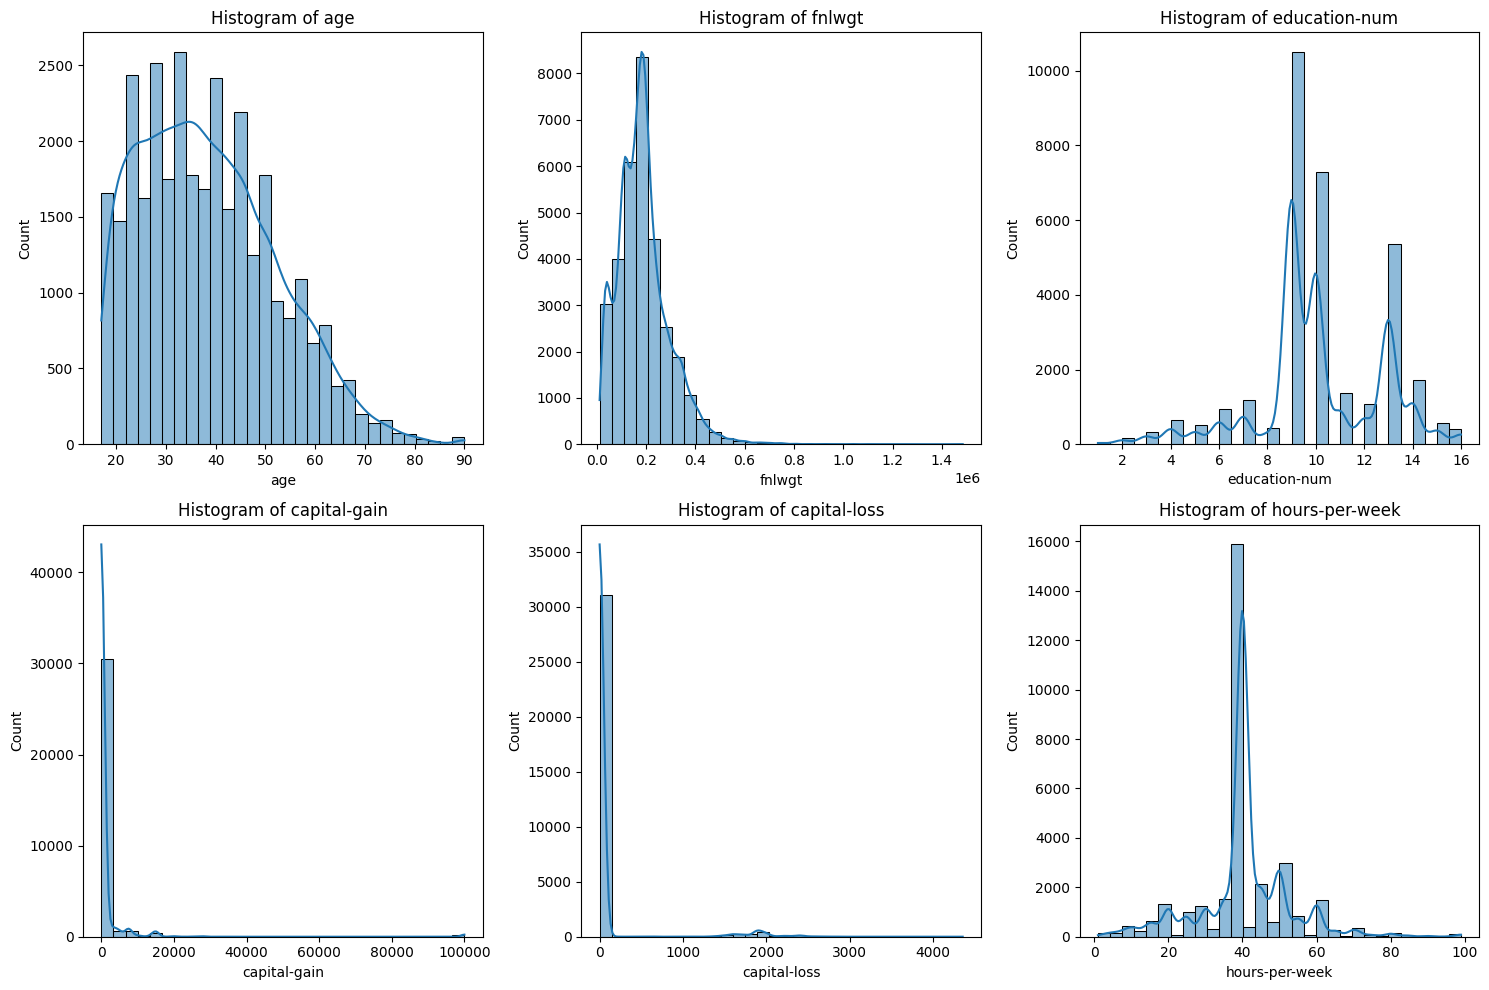

In [93]:
# Histograms
plt.figure(figsize=(15,10))
for i, col in enumerate(numeric_features, 1):
    plt.subplot(2,3,i)
    sns.histplot(df[col], kde =True, bins=30)
    plt.title(f'Histogram of {col}')

plt.tight_layout()
plt.show()

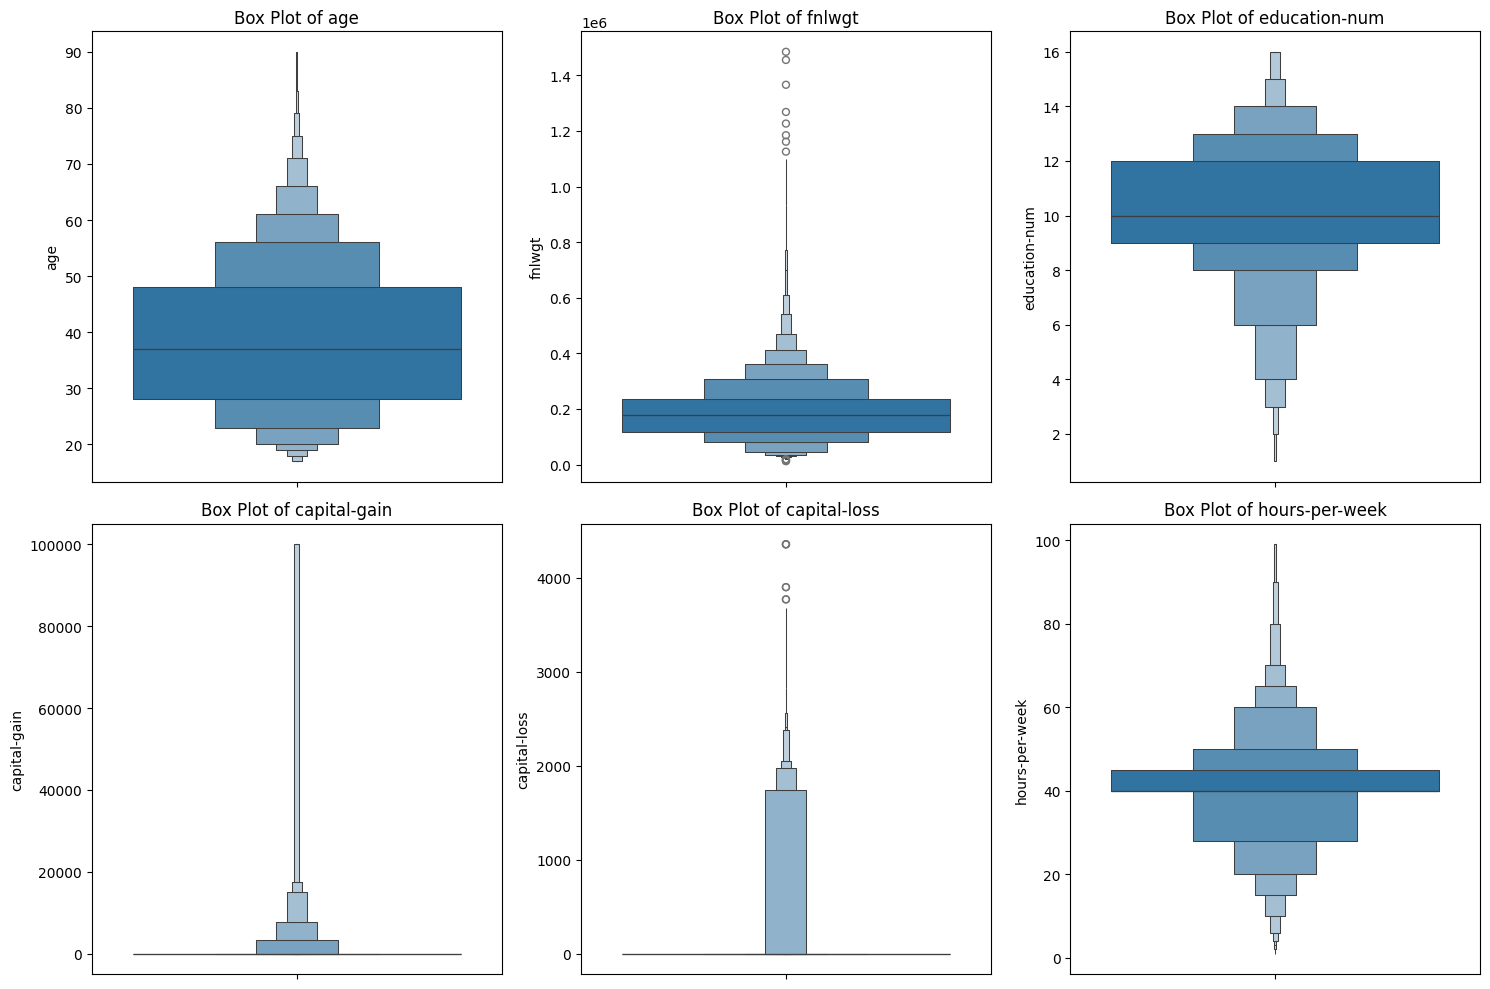

In [94]:
# Box Plots: Identify Outliers and Quartiles
plt.figure(figsize=(15,10))
for i, col in enumerate(numeric_features, 1):
    plt.subplot(2,3,i)
    sns.boxenplot(y=df[col])
    plt.title(f'Box Plot of {col}')
plt.tight_layout()
plt.show()
           

##### What these plots reveal about the data:
• Age Distribution: Most individuals are between 20 and 50 years old. The box plot shows a "tail" of elderly individuals who are statistically outliers but represent real census data.

• Capital Gain/Loss Skewness: These histograms show that the vast majority of records cluster at 0. However, capital-gain has a specific unusual pattern: a frequent cap at 99,999, which appears as a distinct outlier peak on the far right of the histogram.

• Hours-per-Week: We see a massive peak at 40 hours, which is the standard workweek. The box plot  highlights extreme work habits, with values as low as 1 and as high as 99 hours per week.

• Education-Num: This is an ordinal numeric representation of education levels (1–16). Unlike age, this feature is discrete and shows spikes at levels corresponding to High School grads (9) and Bachelors degrees (13).

• Fnlwgt (Final Weight): This represents the number of people the census believes the entry represents. It is highly variable, often exceeding 100,000, and shows a right-skewed distribution

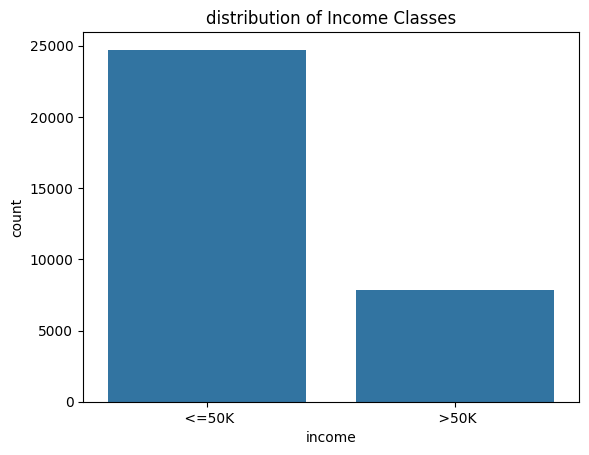

In [95]:
# The target variable in this dataset is income, 
# which is split into two classes: individuals earning <=50K and those earning >50K
sns.countplot(x='income', data=df)
plt.title('distribution of Income Classes')
plt.show()

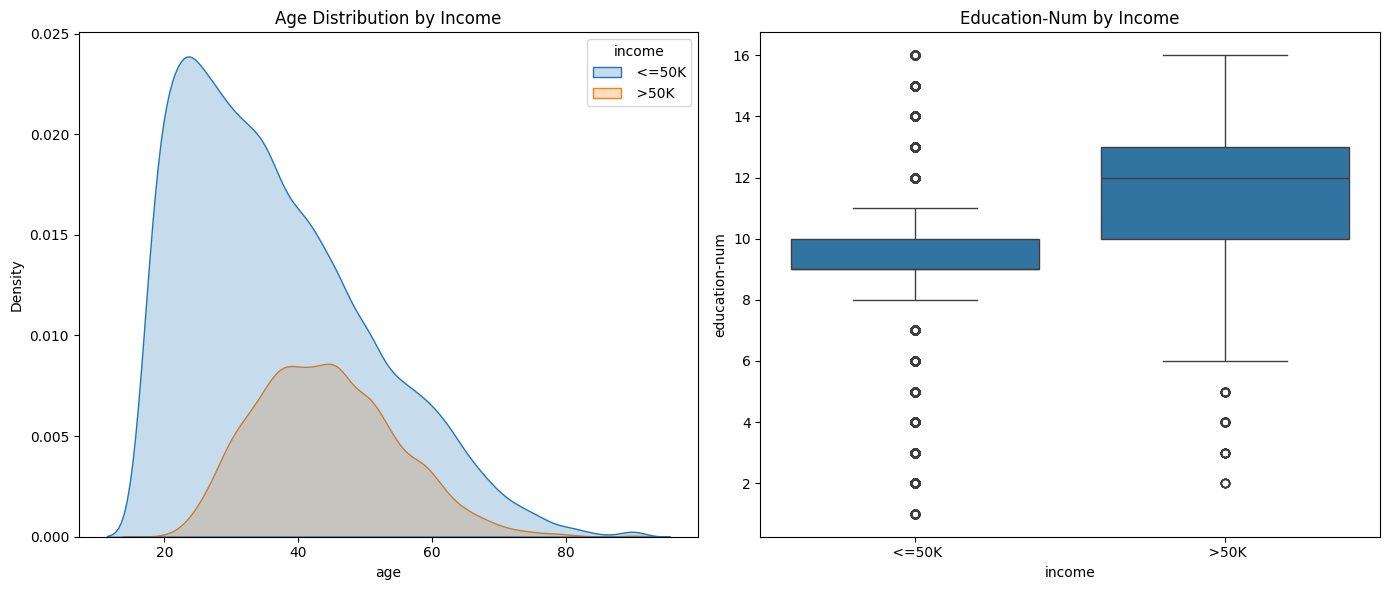

In [96]:
# Compare distributions for continuous variables
plt.figure(figsize=(14, 6))

# Age Comparison
plt.subplot(1, 2, 1)
sns.kdeplot(data=df, x='age', hue='income', fill=True)
plt.title('Age Distribution by Income')

# Education-Num Comparison
plt.subplot(1, 2, 2)
sns.boxplot(x='income', y='education-num', data=df)
plt.title('Education-Num by Income')

plt.tight_layout()
plt.show()

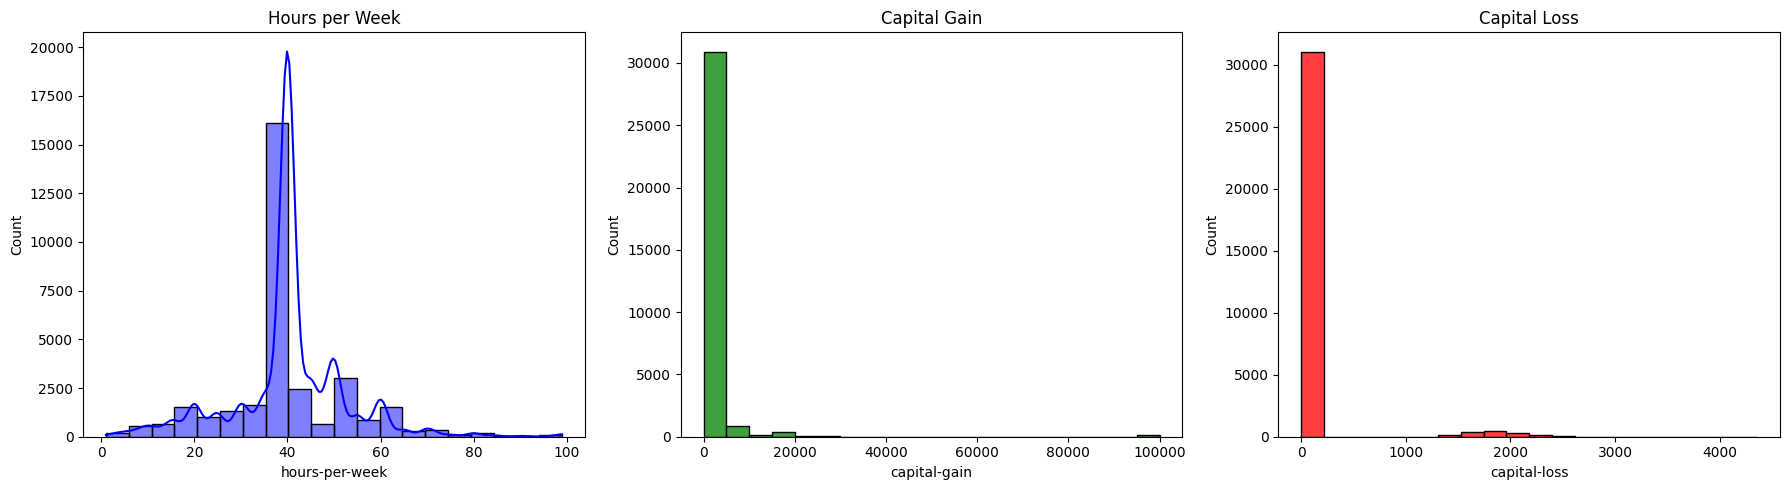

In [97]:
# Create a figure with 1 row and 3 columns of subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 1. Hours-per-week (Select index 0)
sns.histplot(df['hours-per-week'], bins=20, kde=True, ax=axes[0], color='blue')
axes[0].set_title('Hours per Week')

# 2. Capital-gain (Select index 1)
sns.histplot(df['capital-gain'], bins=20, kde=False, ax=axes[1], color='green')
axes[1].set_title('Capital Gain')

# 3. Capital-loss (Select index 2)
sns.histplot(df['capital-loss'], bins=20, kde=False, ax=axes[2], color='red')
axes[2].set_title('Capital Loss')

plt.tight_layout()
plt.show()

- Age Distribution

Individuals earning <=50K tend to be younger, with a heavy concentration in their 20s. In contrast, the >50K class is more evenly distributed across middle age (30s to 50s), where career experience typically peaks.

- Education-Num
There is a visible shift in educational attainment between classes. The >50K group shows high density at values 13 (Bachelors), 14 (Masters), and 15–16 (Professional/Doctorate). Lower income earners cluster at 9 (HS-grad) or below

#### Correlation with target
o check the correlations between your numeric features and the target, you must first map the income labels to numeric values, typically setting >50K as 1 and <=50K as 0

In [99]:
# Convert income to binary 0 and 1
#already done

In [98]:
df.tail(5)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income,target_binary
32555,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K,0
32556,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K,1
32557,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K,0
32558,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,<=50K,0
32559,52,Self-emp-inc,287927,HS-grad,9,Married-civ-spouse,Exec-managerial,Wife,White,Female,15024,0,40,United-States,>50K,1


In [100]:
# Select numeric features and target
numeric_cols = ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week', 'target_binary']

# Calculate correlation matrix
correlation_matrix = df[numeric_cols].corr()

# Print correlations specifically with the income target
print(correlation_matrix['target_binary'].sort_values(ascending=False))

target_binary     1.000000
education-num     0.335182
age               0.234039
hours-per-week    0.229690
capital-gain      0.223333
capital-loss      0.150523
fnlwgt           -0.009481
Name: target_binary, dtype: float64


Notes about Correlation:

education-num: shows the strongest positive correlation with high income, as higher values represent advanced attainment like a Masters or Doctorate.

• capital-gain: Shows a high correlation, largely driven by instances where gains are capped at 99,999, a value found exclusively in high-earner records.

• age: Shows a moderate positive correlation, reflecting that earnings often increase as individuals gain career experience over time.

• hours-per-week: Positively correlated; individuals earning >50K are frequently observed working more than the standard 40-hour workweek.

• fnlwgt (final weight):  shows near-zero correlation with income because it is a calculated population estimate rather than a demographic trait related to earning potential

##### Outliers or unusual patterns

1. The capital-gain 99,999 Cap
A significant unusual pattern is the arbitrary cap of 99,999 in the capital-gain feature. Individuals hitting this cap are almost exclusively labeled with the >50K target class, creating a "cheat code" that causes target leakage.
2. Extreme hours-per-week Values
While most individuals work a standard 40-hour week, there are extreme outliers:
• Maximum (99 hours): Multiple records show individuals working 99 hours per week.
• Minimum (1–2 hours): Some entries, including an 81-year-old, work as little as 1 to 2 hours per week.
3. Missing Value Placeholders
Categorical features like workclass, occupation, and native-country contain a ? placeholder to represent missing information. These are not technically "null" values in a CSV sense, so they must be explicitly handled during preprocessing or they will be treated as a valid category.
4. Age and Education Outliers
• Age: The data includes nonagenarians (age 90) who are still listed as working 40+ hours per week in private or self-employed sectors.
• Education Num: There is a direct mathematical mapping between education and education-num (e.g., Bachelors is always 13). Using both features introduces perfect multi-collinearity, which can destabilize some models.
5. Highly Skewed Distributions
The fnlwgt (final weight) feature contains extreme values, with some records representing over 800,000 people and others representing fewer than 20,000. This feature typically shows no correlation with income and often acts as noise in the model


#### Feature preprocessing

In [166]:
df_prep = df

In [167]:
# 1. Handle missing '?' values as discussed
df_prep = df_prep.replace('?', np.nan)
df_prep = df_prep.fillna(df_prep.mode().iloc)

In [168]:
# 2. Map Sex to Binary
df_prep['sex'] = df_prep['sex'].map({'Male' : 1, 'Female' : 0})

In [169]:
# 3. Define feature groups for processing
std_features = ['age', 'education-num', 'hours-per-week']
robust_features = ['capital-gain', 'capital-loss', 'fnlwgt']
cat_features = ['workclass', 'marital-status', 'occupation', 'relationship', 'race', 'native-country']

In [170]:
# 4. Create the preprocessor
preprocessor = ColumnTransformer(
    transformers= [
        ('std', StandardScaler(), std_features),
        ('robust', RobustScaler(), robust_features),
        ('cat', OneHotEncoder(drop='first', sparse_output=False), cat_features)

    ],
    remainder = 'passthrough'
)

In [171]:
df_prep.head(3)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income,target_binary
0,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,NaN,0,0,13,United-States,<=50K,0
1,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,NaN,0,0,40,United-States,<=50K,0
2,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,NaN,0,0,40,United-States,<=50K,0


In [172]:
# 5. Fit and transform the data
# Drop 'education' as it's redundant with 'education-num'

X = df_prep.drop(columns=['income', 'education'])
X_processed = preprocessor.fit_transform(X)


In [173]:

X_processed = preprocessor.fit_transform(X)

In [174]:
X.head(3)

,age,workclass,fnlwgt,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,target_binary
0,50,Self-emp-not-inc,83311,13,Married-civ-spouse,Exec-managerial,Husband,White,NaN,0,0,13,United-States,0
1,38,Private,215646,9,Divorced,Handlers-cleaners,Not-in-family,White,NaN,0,0,40,United-States,0
2,53,Private,234721,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,NaN,0,0,40,United-States,0


In [175]:
X = X.drop(columns=['fnlwgt'])
X.head(3)

,age,workclass,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,target_binary
0,50,Self-emp-not-inc,13,Married-civ-spouse,Exec-managerial,Husband,White,NaN,0,0,13,United-States,0
1,38,Private,9,Divorced,Handlers-cleaners,Not-in-family,White,NaN,0,0,40,United-States,0
2,53,Private,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,NaN,0,0,40,United-States,0


- features that may leak target information or look suspicious.

Based on the census metadata and dataset excerpts, here are the features that appear suspicious or represent potential target leakage:
1. Capital-Gain (The "99,999" Cap)
The capital-gain feature contains an arbitrary cap at 99,999. Records hitting this cap, such as instances 1682, 5098, and 18149, are almost universally associated with the >50K income class. This value acts as a "shortcut" that allows the model to predict high income without actually learning demographic patterns.
2. Education-Num (Redundancy)
There is a perfect 1-to-1 mapping between the categorical education labels and the numeric education-num feature. for example, "Bachelors" is always "13" and "Masters" is always "14". Using both features introduces perfect multi-collinearity, which can make model coefficients unstable and redundant.
3. Fnlwgt (Final Weight)
The fnlwgt feature is a calculated estimate from the 1994 Census database representing the number of people the record "represents". Because this is a derived population statistic rather than an inherent demographic trait like age or occupation, it often acts as noise rather than a helpful predictor of individual income

### ML modeling foundations


Given the class imbalance in the Adult Census dataset—where roughly 76% of individuals earn <=50K and 24% earn >50K—Standard accuracy is not a reliable metric. A model could achieve 76% accuracy simply by predicting <=50K for every record, while failing to identify a single high earner.

Instead, you should use the following metrics to evaluate your classification task:
• Precision: Measures how many predicted high earners (>50K) actually were high earners. Use this if you want to minimize "false alarms".

• Recall (Sensitivity): Measures how many of the actual high earners the model successfully caught. This is critical if your goal is to find as many high-income individuals as possible.

• F1-Score: This is the harmonic mean of Precision and Recall. It is the best single metric for this dataset because it penalizes models that ignore the minority class (>50K).

• ROC-AUC: Measures the model's ability to distinguish between the two income classes across different probability thresholds.

• Confusion Matrix: Provides a visual breakdown of True Positives, True Negatives, False Positives, and False Negatives, showing exactly where the model is getting confused.

In [176]:
# Cleaning and One-Hot Encoding

# 1. Strip leading/trailing whitespace from all categorical columns
dfx = X.apply(lambda x: x.str.strip() if x.dtype == "object" else x)

# 2. Replace '?' placeholders with NaN and fill them
# Missing values are documented in columns like workclass and occupation [1]
dfx = dfx.replace('?', np.nan)
dfx = dfx.fillna(df.mode().iloc)

# 3. One-Hot Encoding
# This turns categories like 'workclass' into multiple columns of 0s and 1s
X = pd.get_dummies(dfx.drop(columns=['target_binary']), drop_first=True)
y = dfx['target_binary']


In [177]:
# 2. Perform the Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2,      # Allocates 20% of the 48,842 instances to testing
    random_state=42,    # Ensures the split is the same every time you run the code
    stratify=y          # Crucial: Keeps the 76%/24% income balance in both sets
)

print(f"Training set size: {len(X_train)}")
print(f"Testing set size: {len(X_test)}")


Training set size: 26048
Testing set size: 6512


Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.79      0.86      4944
           1       0.57      0.86      0.68      1568

    accuracy                           0.81      6512
   macro avg       0.76      0.83      0.77      6512
weighted avg       0.86      0.81      0.82      6512

ROC-AUC Score: 0.9082


/Users/rom/miniconda3/envs/notebook-env/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:406: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


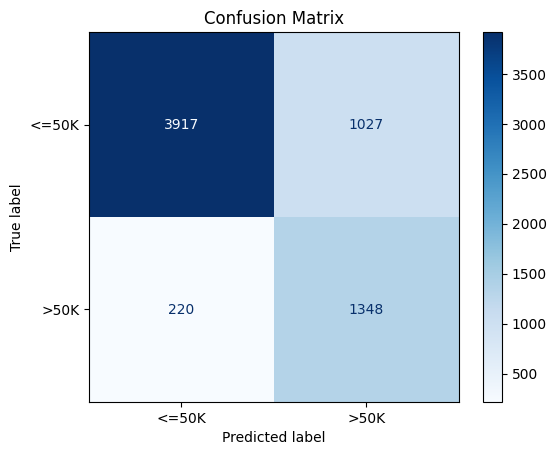

In [181]:
# 1. Initialize the model
# We use class_weight='balanced' to handle the 76%/24% split in the census data
model = LogisticRegression(class_weight='balanced', max_iter=1000)

# 2. TRAIN the model (The missing step!)
model.fit(X_train, y_train)

# 3. Generate predictions and probabilities
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1] # Probability of earning >50K

# 4. Detailed Metrics Table (Precision, Recall, F1-Score)
print("Classification Report:")
print(classification_report(y_test, y_pred))

# 5. ROC-AUC Score (Measures class separation ability)
auc = roc_auc_score(y_test, y_prob)
print(f"ROC-AUC Score: {auc:.4f}")

# 6. Visual Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['<=50K', '>50K'])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

##### Over/Under Fitting explanation
In the context of the Adult Census dataset, these terms describe how well your model learns the relationship between demographic features and the income target.

Underfitting (Too Simple)
Underfitting occurs when a model is too basic to capture the underlying patterns in the data.
• Example: A model that only uses the sex feature to predict income. Because it ignores critical factors like education-num, occupation, and age, it will perform poorly on both your training and testing data, likely guessing the majority class (≤50K) most of the time,.

Overfitting (Too Complex)
Overfitting occurs when a model learns specific "noise" or coincidences in the training set that don't apply to new data.
• Example: A model that relies heavily on the fnlwgt (final weight) column,. Since this is a population estimate rather than an individual trait, a model might "memorize" that a specific weight like 180211 belongs to a high earner. When it sees a new person with that same weight who earns less, the model will make a mistake because it learned a quirk of the training data instead of a general rule

##### Models 
Since the Adult Census dataset is a multivariate classification task with a mix of categorical and integer features, several models are particularly well-suited for it.
Here are the best models to try and why they make sense:

• Logistic Regression: A solid baseline for binary classification. As we've seen, it's efficient for identifying the relationship between features like education-num and the income target, especially when using class_weight='balanced' to handle the 76/24 class split.

• Decision Trees: These are explicitly mentioned in research involving this dataset. They are effective because they naturally handle the mixture of categorical labels (like occupation) and continuous integers (like age) without requiring extensive preprocessing.

• Random Forest or Gradient Boosting (e.g., XGBoost): These ensemble models are often the "gold standard" for tabular data. They are robust to the noise in features like fnlwgt and can capture complex, non-linear patterns—such as how a specific combination of marital-status and education might strongly predict high income.

• Support Vector Machines (SVM): These can find a clear boundary between income classes in a high-dimensional space. However, as we discussed, they are distance-based and highly sensitive to feature scales, making our previous scaling steps essential.

In [182]:
##### Models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import f1_score, roc_auc_score, classification_report


In [183]:
# 1. Define the models
models = {
    "Logistic Regression": LogisticRegression(class_weight='balanced', max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(class_weight='balanced', max_depth=10),
    "Random Forest": RandomForestClassifier(class_weight='balanced', n_estimators=100),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=100)
}

results = []


In [184]:
# 2. Loop through each model to train and evaluate
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]
    
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)
    
    results.append({"Model": name, "F1-Score": f1, "ROC-AUC": auc})
    print(f"--- {name} ---")
    print(classification_report(y_test, y_pred))


/Users/rom/miniconda3/envs/notebook-env/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:406: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


--- Logistic Regression ---
              precision    recall  f1-score   support

           0       0.95      0.79      0.86      4944
           1       0.57      0.86      0.68      1568

    accuracy                           0.81      6512
   macro avg       0.76      0.83      0.77      6512
weighted avg       0.86      0.81      0.82      6512

--- Decision Tree ---
              precision    recall  f1-score   support

           0       0.95      0.80      0.87      4944
           1       0.58      0.87      0.69      1568

    accuracy                           0.82      6512
   macro avg       0.76      0.83      0.78      6512
weighted avg       0.86      0.82      0.83      6512

--- Random Forest ---
              precision    recall  f1-score   support

           0       0.89      0.92      0.90      4944
           1       0.71      0.65      0.68      1568

    accuracy                           0.85      6512
   macro avg       0.80      0.78      0.79      6512
we

In [185]:
# 3. Find the best model based on F1-Score
best_model = max(results, key=lambda x: x['F1-Score'])
print(f"\nBest performing model: {best_model['Model']} with F1: {best_model['F1-Score']:.4f}")



Best performing model: Gradient Boosting with F1: 0.6957


##### Visualizing Feature Importances

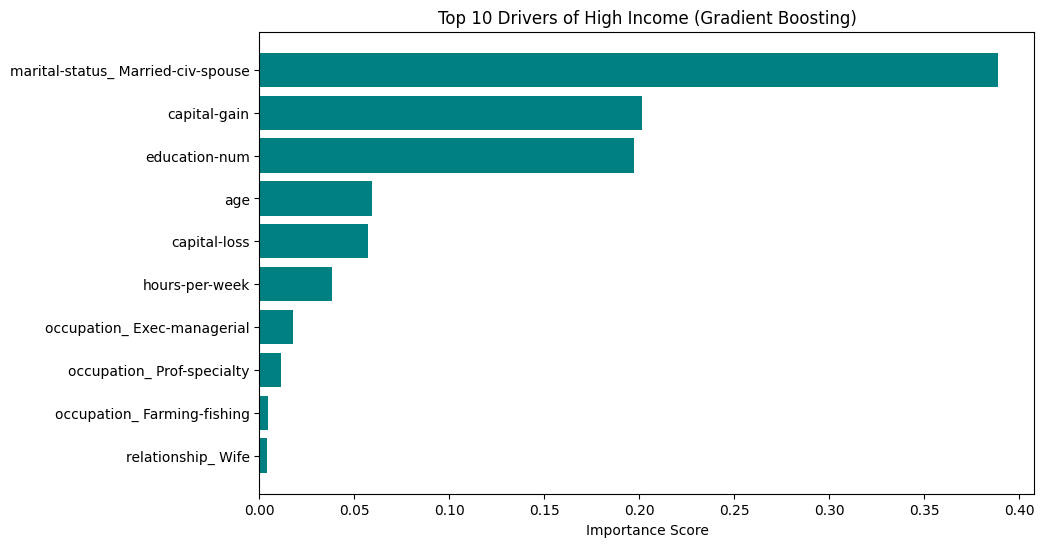

In [186]:
# 1. Extract importances from your best model
# Ensure 'models["Gradient Boosting"]' is the key from our previous code
best_model = models["Gradient Boosting"]
importances = best_model.feature_importances_

# 2. Match importances to feature names
feature_names = X_train.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

# 3. Sort and plot the top 10
top_features = feature_importance_df.sort_values(by='Importance', ascending=False).head(10)

plt.figure(figsize=(10, 6))
plt.barh(top_features['Feature'], top_features['Importance'], color='teal')
plt.xlabel("Importance Score")
plt.title("Top 10 Drivers of High Income (Gradient Boosting)")
plt.gca().invert_yaxis()
plt.show()

### adult.test testing

In [190]:
# 1. Load the test file (skiprow=1 skips the header disclaimer in adult.test)
column_names = ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 
                'marital-status', 'occupation', 'relationship', 'race', 'sex', 
                'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'income']

df_test = pd.read_csv('DATA/adult/adult.test', skiprows=1, names=column_names, skipinitialspace=True)

# 2. Clean trailing dots in labels and strip whitespace
df_test['income'] = df_test['income'].str.replace('.', '', regex=False)
df_test = df_test.replace('?', np.nan).dropna() # Or use mode imputation as before

# 3. Preprocess Features (Drop redundant/noise columns)
X_test_unseen = df_test.drop(columns=['income', 'education', 'fnlwgt'])
y_test_unseen = df_test['income'].map({'>50K': 1, '<=50K': 0})

# 4. One-Hot Encoding and Alignment
X_test_unseen = pd.get_dummies(X_test_unseen, drop_first=True)

# Crucial: Ensure the test columns match the training columns exactly
X_test_unseen = X_test_unseen.reindex(columns=X_train.columns, fill_value=0)

# 5. Predict and Evaluate
y_pred_unseen = model.predict(X_test_unseen)
print("Results on adult.test:")
print(classification_report(y_test_unseen, y_pred_unseen))

Results on adult.test:
              precision    recall  f1-score   support

           0       0.79      1.00      0.88     11360
           1       0.98      0.19      0.31      3700

    accuracy                           0.80     15060
   macro avg       0.89      0.59      0.60     15060
weighted avg       0.84      0.80      0.74     15060



#### The Results
These results show that while your model is highly accurate when it does predict a high earner (98% precision), it has become extremely conservative on the official unseen test data. It is currently missing 81% of actual high earners, resulting in a very low recall of 0.19 and a poor F1-score of 0.31.

Analysis of the Performance Drop

• Misleading Accuracy: The 80% accuracy is only slightly better than the baseline of ~76% you would get by simply guessing <=50K for every record in the 1994 Census database.

• Precision vs. Recall Trade-off: The near-perfect precision (0.98) means the model only predicts >50K when it is absolutely certain. However, the low recall suggests it is failing to identify the vast majority of high-income individuals in the test set.

• Generalization Gap: The drop from an F1-score of ~0.70 on your initial test split to 0.31 on adult.test suggests the model is struggling to generalize to this specific official test set.

Why did this happen?
This often occurs if the final model was not trained with a balancing strategy (like class_weight='balanced') or if the classification threshold is too high. Since the dataset is inherently imbalanced (~76% to ~24%), the model is defaulting to the majority class to minimize errors

#### Asumptions about Models used
The machine learning models used for this dataset make several key assumptions, some of which are more realistic than others:
1. Linear Relationship (Logistic Regression)
• Assumption: Logistic Regression assumes a linear relationship between the log-odds of income and the features (like age or education-num).
• Realism: This is often unrealistic. Earning potential usually follows non-linear patterns—for example, income often plateaus or decreases after a certain age rather than increasing infinitely.

2. Feature Independence
• Assumption: Models assume that features provide independent information.
• Realism: Unrealistic without preprocessing. The 1-to-1 mapping between education labels and education-num creates perfect multi-collinearity. This is why we dropped the redundant text column to avoid destabilizing the model.

3. Data Uniformity (Outliers and Caps)
• Assumption: Models assume that numeric values like capital-gain represent a continuous, consistent scale.
• Realism: Suspicious. The arbitrary cap at 99,999 for capital-gain acts as a hidden label for high income rather than a true numeric value. Models can "cheat" by learning this cap instead of actual demographic trends.

4. Representative Weighting (fnlwgt)
• Assumption: Models might assume fnlwgt (final weight) is a predictive trait of an individual's income.
• Realism: Unrealistic. This is a derived database statistic representing population proportions, not a personal characteristic. It usually acts as noise, which is why we decided to drop it.

5. Categorical Homogeneity
• Assumption: One-Hot Encoding assumes there is no mathematical order between categories (e.g., Private workclass is not "greater" than Local-gov).
• Realism: Realistic for nominal features like occupation or native-country.
Tree-based models (Random Forest and Gradient Boosting) are generally more realistic for this dataset because they do not assume linearity and can capture complex interactions between attributes like marital status and education.

#### What can go wrong?

Deploying a model that works well on the Adult Census dataset into the real world presents several significant risks, primarily due to the age of the data and its inherent biases.
1. Temporal Obsolescence (Data Drift)
The most immediate issue is that this dataset was extracted in 1996 from a 1994 database. Economic conditions, inflation rates, and job markets have changed drastically since then. Predicting whether someone earns over $50,000 was a high-income benchmark in 1994, but it is no longer a representative threshold for high earning in the modern economy. A model trained on these patterns would likely fail to provide meaningful insights for today's financial landscape.

2. Learned Artificial Patterns (Target Leakage)
As we noted earlier, the feature capital-gain contains an arbitrary cap at 99,999. In the dataset, hitting this cap is almost a guarantee of being in the >50K class. In the real world, capital gains are not capped at a specific five-digit number in the same way, so a model that has "memorized" this specific value as a shortcut to prediction will be much less accurate on real data that lacks this artificial cap.

3. Ethical Bias and Fairness
The dataset explicitly includes sensitive demographic markers like race, sex, and native-country. Because the 1994 data reflects the historical societal biases of that time, a model could learn to discriminate—for example, by predicting lower income for certain racial groups or genders based solely on those labels rather than individual capability. Using such a model for modern loan approvals or hiring would lead to unethical and potentially illegal outcomes.

4. Preprocessing Sensitivity
The dataset uses the ? character as a placeholder for missing values in categories like workclass and occupation. Real-world production systems will encounter missing values in different formats and columns, making the hard-coded cleaning steps used for this specific census data brittle and unreliable.

#### Baseline Model

A simple baseline for this dataset is a Majority Class Classifier (or ZeroR), which simply predicts the most frequent target: <=50K,. Alternatively, a Logistic Regression model is the standard practical starting point for binary classification tasks involving mixed integer and categorical census data,.
Starting with a baseline is critical because:

• Benchmarking: It sets a performance "floor." Since roughly 76% of the records are <=50K, a model that only achieves 76% accuracy is performing no better than a blind guess of the majority class,.

• Complexity Check: It helps determine if simple linear patterns—such as a higher education-num leading to higher income—are sufficient, or if you truly need complex models like Gradient Boosting to capture non-linear relationships,.

• Evaluation Clarity: It highlights the necessity of using metrics like the F1-score, as a baseline model for this imbalanced dataset will have a recall of 0% for the high-income group

In [192]:
#To implement threshold adjustment, you move away from the default 0.5 probability cutoff. 
# By lowering this cutoff, you make the model less "strict" 
# about predicting high earners (>50K), which directly increases Recall.
# Implementation
#Instead of using .predict(), you use .predict_proba() to get the raw likelihoods and apply your own limit:

# 1. Get raw probabilities for the positive class (>50K)
y_probs = model.predict_proba(X_test_unseen)[:, 1]

# 2. Set a lower threshold (e.g., 0.3 instead of 0.5)
# This forces the model to label someone as '>50K' if it is even 30% sure
custom_threshold = 0.2
y_pred_adjusted = (y_probs >= custom_threshold).astype(int)

# 3. Re-evaluate the results
print(f"Results with Adjusted Threshold ({custom_threshold}):")
print(classification_report(y_test_unseen, y_pred_adjusted))


Results with Adjusted Threshold (0.2):
              precision    recall  f1-score   support

           0       0.82      0.98      0.89     11360
           1       0.83      0.32      0.46      3700

    accuracy                           0.82     15060
   macro avg       0.82      0.65      0.68     15060
weighted avg       0.82      0.82      0.78     15060



Lowering the threshold to 0.2 significantly boosted your Recall for high earners to 0.32, up from the original 0.19. Your F1-score has also climbed to 0.46, indicating a much better balance between finding high earners and maintaining accuracy.

Analysis of the 0.2 Threshold Results
• Catching More High Earners: You are now identifying 32% of those earning >50K in the 1994 Census database.

• Precision vs. Recall: As expected, your precision dropped from 0.93 to 0.83. This means about 17% of your ">50K" predictions are now "false alarms," but the model is successfully finding nearly a third of the target group.

• The Remaining Gap: Despite this progress, the model still misses 68% of high earners in the official adult.test set. Because the dataset is multivariate and contains complex categorical interaction—like occupation and education-num—threshold shifting can only do so much